In [1]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator


import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 




PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')

CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/rw_varying_bound_confirmatory/")
stimdur = '250'

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]


# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()
df.shape
df.head()

count.max()
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


/tmp/ipykernel_688706/152470543.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_688706/152470543.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_688706/152470543.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [2]:
dataset,dataset_resp = make_dataset(9, count,chain_matrix)

In [3]:
dataset[0]

array([-1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.])

In [4]:
def get_weighted_x(mat):
    '''create a weight matrix for x_train for example'''
    mat_weighted = np.zeros_like(mat)
    for i, j in enumerate(mat):
        mat_weighted[i,:] = get_confirm_weights(j) 
    return mat_weighted
# this is the best model
def get_weighted_random_walk_position(x):
    x = get_weighted_x(x) * get_abs_evidence(x)
    # x = np.abs(np.diff(x))
    return x

/tmp/ipykernel_688706/1617608547.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


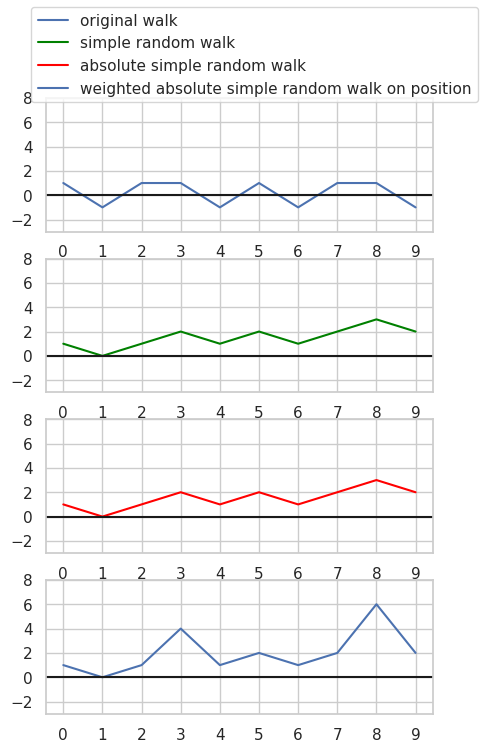

In [5]:
walk = 3
chain = dataset[walk]
fig, ax = plt.subplots(4,1, figsize=(5,8))
ax[0].plot(dataset[walk], label = 'original walk')
ax[1].plot(get_evidence(dataset)[walk], label = 'simple random walk',color = 'green')
ax[2].plot(get_abs_evidence(dataset)[walk],label = 'absolute simple random walk',color= 'red')
ax[3].plot(get_weighted_random_walk_position(dataset)[walk],label = 'weighted absolute simple random walk on position')


for a in ax:
    a.set_ylim(-3,8)
    a.axhline(0,color='k')
    a.yaxis.set_major_locator(MaxNLocator(integer=True))
    a.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.legend()
fig.show()

In [6]:
chain = dataset[10]

In [7]:
chain1 = chain.copy()
chain1[chain==-1] =0

In [8]:
chain

array([ 1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1.])

In [9]:
def get_cumsum_reset_with_weights(chain):
    cumsum =[]
    weights = get_confirm_weights(chain)
    for i in range(len(chain)):
        if weights[i] == 1:
            cumsum.append(chain[i])
        else:
            val =  chain[i]* weights[i]
            cumsum.append(cumsum[-1] + val)
    return weights, cumsum 

In [10]:
weights, cumsum = get_cumsum_reset_with_weights(chain)

In [11]:
cumsum

[1.0, 3.0, 6.0, -1.0, -3.0, -6.0, -10.0, 1.0, -1.0, -3.0]

In [12]:
np.diff(np.abs(cumsum))

array([ 2.,  3., -5.,  2.,  3.,  4., -9.,  0.,  2.])

In [ ]:
get_confirm_weights(chain1)

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 1])

In [ ]:

def get_confirm_weights(chain):
    output = [1]  # Start with the first element always being 1
    counter = 0   # Counter for consecutive matches
    cumsum = 1
    # Start from the second element and compare with the previous one
    for i in range(1, len(chain)):
        if chain[i] == chain[i - 1]:
            cumsum = cumsum +1
            output.append(cumsum)

        else:
            cumsum = 1
            output.append(cumsum)

    return np.array(output)


In [14]:
chain

array([ 1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1.])

In [43]:
cumsum = np.cumsum(chain)

In [44]:
cumsum.shape

(10,)

In [82]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.metrics.pairwise import linear_kernel


kernel = [[1,-1,1,1]]
cs = cosine_similarity([[1,1,1,1]], kernel)
cs = np.dot([[1,1,1,1]], np.array(kernel).T)

In [83]:
print(cs)

[[2]]
